In [1]:
#dependencies
from string import punctuation
from os import listdir
from numpy import array
from numpy import asarray
from numpy import zeros
import pandas as pd
import numpy as np
from numpy import array
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

Using TensorFlow backend.


In [2]:
def load_data(filename,encoding):
    data = pd.read_csv(filename,encoding=encoding)
    return data

def create_train_test_sets(data,split):
    np.random.seed(0)
    mask = np.random.rand(len(data)) < split
    train_data = data[mask]
    test_data = data[~mask]
    return train_data,test_data

def clean_and_get_tokens(doc):
    tokens = doc.split()
    table = str.maketrans('','',punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if len(word)>2]
    return tokens

In [3]:
data = load_data('bbc/BBC_news.csv','latin1')
words = set()
vocab = {}


token = data['texts'][0].split()
table = str.maketrans('','',punctuation)
tokens = [w.translate(table) for w in token] 
#print(tokens)
tokens = [word for word in tokens if word.isalpha()]
tokens = [word for word in tokens if len(word)>2]
#print(tokens)

documents = data['texts']
for doc in documents:
    tokens = clean_and_get_tokens(doc)
    for token in tokens:
        if token in vocab:
            vocab[token] += 1
        else:
            vocab[token] = 1

for word in vocab:
    if vocab[word] > 5:
        words.add(word)



train_data,test_data = create_train_test_sets(data,0.8)

train_documents = []
for doc in train_data['texts']:
    tokens = doc.split()
    final_tokens = []
    #final_string = ''
    for token in tokens:
        if token in words:
            final_tokens.append(token)
    final_string = ' '.join(final_tokens)
    train_documents.append(final_string)

test_documents = []
for doc in test_data['texts']:
    tokens = doc.split()
    final_tokens = []
    #final_string = ''
    for token in tokens:
        if token in words:
            final_tokens.append(token)
    final_string = ' '.join(final_tokens)
    test_documents.append(final_string)

In [4]:
def load_embedding(filename,encoding): 
    file = open(filename,'r',encoding=encoding)
    lines = file.readlines()[1:]
    file.close()
    embedding = dict()
    for line in lines:
        parts = line.split()
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_documents)
encoded_docs = tokenizer.texts_to_sequences(train_documents)

max_length = max(([len(s.split()) for s in train_documents]))
labels = train_data['CAT']
train_labels = labels
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
ytrain = keras.utils.to_categorical(labels, num_classes=5)

In [6]:
encoded_docs = tokenizer.texts_to_sequences(test_documents)
labels = test_data['CAT']
Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
ytest = keras.utils.to_categorical(labels, num_classes=5)

In [7]:
vocab_size = len(tokenizer.word_index)+1
raw_embedding = load_embedding('glove.6B.100d.txt','utf8')

weight_matrix = zeros((vocab_size, 100))
for word,i in tokenizer.word_index.items():
    if word in raw_embedding:
        weight_matrix[i] = raw_embedding[word]
embedding_layer = Embedding(vocab_size, 100, weights=[weight_matrix], input_length=max_length, trainable=True)

In [8]:
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length = max_length))
model.add(Conv1D(filters=16, kernel_size=16, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2687, 100)         882500    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2672, 16)          25616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1336, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21376)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 21376)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 106885    
Total params: 1,015,001
Trainable params: 1,015,001
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, ytrain, epochs=3, verbose=2, validation_data = (Xtest,ytest))

Train on 1753 samples, validate on 472 samples
Epoch 1/3
 - 19s - loss: 1.5356 - acc: 0.3155 - val_loss: 1.4198 - val_acc: 0.3347
Epoch 2/3
 - 7s - loss: 0.7445 - acc: 0.7268 - val_loss: 0.3407 - val_acc: 0.8771
Epoch 3/3
 - 8s - loss: 0.0879 - acc: 0.9749 - val_loss: 0.1624 - val_acc: 0.9513


In [10]:
random_text = ["I love business and sports"]
encoded_text = tokenizer.texts_to_sequences(random_text)
test_text = pad_sequences(encoded_text, maxlen = max_length, padding= 'post')
model.predict(test_text)

array([[1.4175244e-05, 8.4548783e-01, 1.4801595e-01, 3.5826231e-03,
        2.8994626e-03]], dtype=float32)

In [11]:
ypred = model.predict(Xtest)
pred_labels = []
for probs in ypred:
    label = np.argmax(probs, axis=-1)
    pred_labels.append(int(label))
actual_labels = list(labels)

In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual_labels, pred_labels)

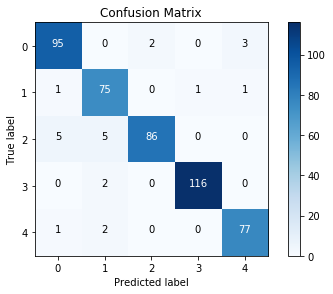

In [14]:
import matplotlib.pyplot as plt
import itertools
cmap = plt.cm.Blues
title = "Confusion Matrix"
classes = 5
normalize = False
tick_marks = np.arange(classes)
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(5)
#plt.xticks(tick_marks, classes, rotation=45)
#plt.yticks(tick_marks, classes)

fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()